In [106]:
import os
import sys
# 1. 현재 작업 디렉토리(CWD)를 부모 폴더(프로젝트 루트)로 변경
# (현재 위치가 'models' 폴더일 경우에만 실행하도록 안전장치 추가)
if os.path.basename(os.getcwd()) == 'models':
    os.chdir('..')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# 데이터 처리
import pandas as pd
import numpy as np
import math
import os
from tqdm import tqdm
import easydict
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 프로젝트 모듈 (기존 .py 파일들)
from dataset import create_dataloaders, collate_fn
from utils import hist_conversations_length, augment_csv
from preprocessing import preprocess_sentence

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using device: {device}')

# 재현성을 위한 시드 설정
torch.manual_seed(2)
if torch.backends.mps.is_available():
    pass
    # torch.backends.mps.manual_seed_all(42)
np.random.seed(2)

Using device: mps


In [107]:
TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/train.csv"
TEST_PATH = "./Data/aiffel-dl-thon-dktc-online-15/test.csv"
SUBMIT_PATH = "./Data/aiffel-dl-thon-dktc-online-15/submission.csv"
BEST_MODEL_PATH = "./models/best_model_classification_only.pt"


# 1. 모델 정의

In [108]:
class MultiHeadAttention(nn.Module):
    """GPT-1 스타일 Causal Multi-Head Self-Attention"""
    
    def __init__(self, emb_dim, num_heads, dropout=0.1, bias=False):
        super().__init__()
        assert emb_dim % num_heads == 0
        
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, emb_dim = x.shape
        
        # Q, K, V projections
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Causal mask (미래 토큰 참조 방지)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))
        
        # Softmax & dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, emb_dim)
        
        return self.out_proj(attn_output)

In [109]:
class PositionWiseFeedForward(nn.Module):
    """Position-wise FFN with GELU activation"""
    
    def __init__(self, emb_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, ffn_dim)
        self.w_2 = nn.Linear(ffn_dim, emb_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))


class PositionalEmbedding(nn.Embedding):
    """Learned Positional Embedding"""
    
    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim, padding_idx=padding_idx)
        # Initialize weights with small normal distribution
        nn.init.normal_(self.weight, mean=0.0, std=0.01)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        # Return positions directly - broadcasting will handle batch dimension
        return super().forward(positions)

In [110]:
class DecoderLayer(nn.Module):
    """Decoder Layer (Pre-LN)"""
    
    def __init__(self, config):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(
            emb_dim=config.emb_dim,
            num_heads=config.num_heads,
            dropout=config.dropout,
            bias=False
        )
        
        self.ffn = PositionWiseFeedForward(
            emb_dim=config.emb_dim,
            ffn_dim=config.ffn_dim,
            dropout=config.dropout
        )
        
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x, mask=None):
        # Pre-LN: Norm -> Attention -> Residual
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, mask=mask)
        x = self.dropout(x)
        x = residual + x
        
        # Pre-LN: Norm -> FFN -> Residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = residual + x
        
        return x


class Decoder(nn.Module):
    """Decoder"""
    
    def __init__(self, config, embedding_layer):
        super().__init__()
        
        self.embed_tokens = embedding_layer
        self.embed_positions = PositionalEmbedding(
            num_positions=config.max_seq_len,
            embedding_dim=config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        self.layers = nn.ModuleList([
            DecoderLayer(config) for _ in range(config.num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, input_ids, mask=None):
        x = self.embed_tokens(input_ids)
        x = x + self.embed_positions(input_ids)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask=mask)
        
        x = self.final_norm(x)
        return x

In [111]:
class GPT1Classifier(nn.Module):
    """Text Classification (CLASSIFICATION ONLY - NO LANGUAGE MODELING)"""
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Shared token embedding
        self.dec_embedding = nn.Embedding(
            config.vocab_size,
            config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        # GPT-1 Decoder
        self.decoder = Decoder(config, self.dec_embedding)
        
        # ⚡ CHANGE: ONLY Classification Head (NO Language Modeling Head)
        self.classification_head = nn.Sequential(
            nn.Dropout(0.3),  # Higher dropout for regularization
            nn.Linear(config.emb_dim, config.emb_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.emb_dim, config.num_classes)
        )
        
    def forward(self, input_ids):
        # Decoder
        hidden_states = self.decoder(input_ids)
        
        # ⚡ CHANGE: ONLY return classification logits
        # Use LAST token (causal mask compatible)
        cls_hidden = hidden_states[:, -1, :]  
        # cls_hidden, _ = torch.max(hidden_states, dim=1)
        # cls_logits = self.classification_head(cls_hidden)
        # cls_hidden = hidden_states.mean(dim=1) 
        cls_logits = self.classification_head(cls_hidden)
        
        return cls_logits  # ⚡ ONLY classification logits (no LM logits)

# 2. Helper
- Augementation 진행

In [112]:
# augment_csv(
#         input_csv_path=TRAIN_PATH,
#         output_csv_path=AUGMENTED_TRAIN_PATH,
#         text_columns=['input_text', 'target_text'],  # 증강할 텍스트 컬럼
#         label_column='label',
#         augment_ratio=2,  # 2배 증강
#         dropout_rate=0.15,
#         exclude_labels=[4]  # 제외할 레이블 결정. 숫자 리스트로 주면 됨 EX. 1(협박대화), ... ,4(일반대화)
#     )

# 3. train 함수

In [113]:
def train_epoch(model, train_loader, optimizer, criterion, scheduler, device, epoch):
    """한 에폭 학습 (CLASSIFICATION ONLY)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # ⚡ CHANGE: Model only returns cls_logits (no lm_logits)
        cls_logits = model(input_ids)
        
        # ⚡ CHANGE: Only classification loss (no LM loss)
        loss = criterion(cls_logits, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(cls_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    return total_loss / len(train_loader), 100 * correct / total


def validate_epoch(model, val_loader, criterion, device, epoch):
    """검증 (CLASSIFICATION ONLY)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation {epoch}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # ⚡ CHANGE: Model only returns cls_logits
            cls_logits = model(input_ids)
            
            # ⚡ CHANGE: Only classification loss
            loss = criterion(cls_logits, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(cls_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(val_loader), 100 * correct / total

# 4. 하이퍼파라미터 설정

In [114]:
VALIDATION_SPLIT = 0.1

# ============================================================================
# 고정 파라미터 (PDF 명세서 기준)
# ============================================================================
VOCAB_SIZE = 1350      # Changed: 1300 -> 1350
MAX_LENGTH = 450       # Changed: 380 -> 450
NUM_LAYERS = 1        # Changed: 1 -> 2 ⚠️ IMPORTANT!
NUM_CLASSES = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 200       # Changed: 500 -> 150
PATIENCE = 10          # Changed: 20 -> 10

# ============================================================================
# 하이퍼파라미터 튜닝 그리드
# ============================================================================
SEARCH_GRID = {
    'BATCH_SIZE': [32, 64],
    'EMB_DIM': [64, 128],
    'FFN_DIM': [256, 512],
    'NUM_HEADS': [1, 2, 4, 8],
    'DROPOUT': [0.2],
}

# 기본값 (단일 실행용)
BATCH_SIZE = 32
EMBEDDING_DIM = 64
FFN_DIM = 256
NUM_HEADS = 1
DROPOUT = 0.2

# 결과 디렉토리
RESULTS_DIR = "./hyperparameter_results"
import os
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs("./models/experiments", exist_ok=True)

print("="*80)
print("🔧 하이퍼파라미터 설정")
print("="*80)
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
print(f"MAX_LENGTH: {MAX_LENGTH}")
print(f"NUM_LAYERS: {NUM_LAYERS} ")
print(f"NUM_EPOCHS: {NUM_EPOCHS}")
print(f"PATIENCE: {PATIENCE}")
print("="*80)

🔧 하이퍼파라미터 설정
VOCAB_SIZE: 1350
MAX_LENGTH: 450
NUM_LAYERS: 1 
NUM_EPOCHS: 200
PATIENCE: 10


# 하이퍼파라미터 튜닝 + Submission 자동 생성

In [115]:
import itertools

def generate_param_combinations(search_grid):
    keys = list(search_grid.keys())
    values = [search_grid[k] for k in keys]
    combinations = []
    for combo in itertools.product(*values):
        param_dict = dict(zip(keys, combo))
        combinations.append(param_dict)
    return combinations

all_combinations = generate_param_combinations(SEARCH_GRID)
total_combos = len(all_combinations)
per_person = total_combos // 3
kim_wansu_combinations = all_combinations[0:]

print(f"\n{'='*80}")
print(f"실험 조합")
print(f"{'='*80}")
print(f"총 조합 수: {total_combos}")
print(f"김완수 실험: {len(kim_wansu_combinations)}개 (1-{len(kim_wansu_combinations)})")
print(f"\n처음 3개:")
for i, combo in enumerate(kim_wansu_combinations[:], 2):
    print(f"  {i}. BS={combo['BATCH_SIZE']}, EMB={combo['EMB_DIM']}, "
          f"FFN={combo['FFN_DIM']}, HEADS={combo['NUM_HEADS']}, DROP={combo['DROPOUT']}")


실험 조합
총 조합 수: 32
김완수 실험: 32개 (1-32)

처음 3개:
  2. BS=32, EMB=64, FFN=256, HEADS=1, DROP=0.2
  3. BS=32, EMB=64, FFN=256, HEADS=2, DROP=0.2
  4. BS=32, EMB=64, FFN=256, HEADS=4, DROP=0.2
  5. BS=32, EMB=64, FFN=256, HEADS=8, DROP=0.2
  6. BS=32, EMB=64, FFN=512, HEADS=1, DROP=0.2
  7. BS=32, EMB=64, FFN=512, HEADS=2, DROP=0.2
  8. BS=32, EMB=64, FFN=512, HEADS=4, DROP=0.2
  9. BS=32, EMB=64, FFN=512, HEADS=8, DROP=0.2
  10. BS=32, EMB=128, FFN=256, HEADS=1, DROP=0.2
  11. BS=32, EMB=128, FFN=256, HEADS=2, DROP=0.2
  12. BS=32, EMB=128, FFN=256, HEADS=4, DROP=0.2
  13. BS=32, EMB=128, FFN=256, HEADS=8, DROP=0.2
  14. BS=32, EMB=128, FFN=512, HEADS=1, DROP=0.2
  15. BS=32, EMB=128, FFN=512, HEADS=2, DROP=0.2
  16. BS=32, EMB=128, FFN=512, HEADS=4, DROP=0.2
  17. BS=32, EMB=128, FFN=512, HEADS=8, DROP=0.2
  18. BS=64, EMB=64, FFN=256, HEADS=1, DROP=0.2
  19. BS=64, EMB=64, FFN=256, HEADS=2, DROP=0.2
  20. BS=64, EMB=64, FFN=256, HEADS=4, DROP=0.2
  21. BS=64, EMB=64, FFN=256, HEADS=8, DROP

In [116]:
import pandas as pd
from datetime import datetime

class ExperimentTracker:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        if os.path.exists(csv_path):
            self.results = pd.read_csv(csv_path)
            print(f"기존 결과: {len(self.results)}개")
        else:
            self.results = pd.DataFrame()
            print("새 실험 시작")
    
    def log_result(self, exp_id, params, metrics, submission_file):
        result = {
            'exp_id': exp_id, 'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'name': '김완수', 'VOCAB_SIZE': VOCAB_SIZE, 'MAX_LENGTH': MAX_LENGTH,
            'BATCH_SIZE': params['BATCH_SIZE'], 'EMB_DIM': params['EMB_DIM'],
            'FFN_DIM': params['FFN_DIM'], 'NUM_HEADS': params['NUM_HEADS'],
            'DROPOUT': params['DROPOUT'], 'NUM_LAYERS': NUM_LAYERS,
            'PATIENCE': PATIENCE, 'LR': LEARNING_RATE,
            'best_val_loss': metrics['best_val_loss'], 'best_val_acc': metrics['best_val_acc'],
            'val_f1_macro': metrics.get('val_f1_macro', 0),
            'val_f1_weighted': metrics.get('val_f1_weighted', 0),
            'epochs_trained': metrics['epochs'], 'training_time_min': metrics['time'] / 60,
            'early_stopped': metrics['early_stopped'], 'model_path': metrics['model_path'],
            'submission_file': submission_file,
        }
        self.results = pd.concat([self.results, pd.DataFrame([result])], ignore_index=True)
        self.results.to_csv(self.csv_path, index=False)
        return result
    
    def get_completed_experiments(self):
        return set(self.results['exp_id'].values) if len(self.results) > 0 else set()
    
    def get_best_experiment(self, metric='best_val_loss'):
        return self.results.loc[self.results[metric].idxmin()] if len(self.results) > 0 else None
    
    def print_summary(self, top_n=5):
        if len(self.results) == 0:
            print("완료된 실험 없음")
            return
        print(f"\n{'='*80}\n실험 요약: {len(self.results)}개 완료\n{'='*80}")
        print(f"\n🏆 Top {top_n}:")
        top = self.results.nsmallest(top_n, 'best_val_loss')
        for rank, (idx, row) in enumerate(top.iterrows(), 1):
            print(f"\n{rank}위: 실험 {int(row['exp_id'])} | Loss: {row['best_val_loss']:.4f} | Acc: {row['best_val_acc']:.2f}%")
            print(f"  F1: {row['val_f1_macro']:.4f}/{row['val_f1_weighted']:.4f} | "
                  f"BS={int(row['BATCH_SIZE'])}, EMB={int(row['EMB_DIM'])}, FFN={int(row['FFN_DIM'])}, "
                  f"H={int(row['NUM_HEADS'])}, D={row['DROPOUT']}")
            print(f"{row['training_time_min']:.1f}min, {int(row['epochs_trained'])}ep")
            print(f"{row['submission_file']}")

tracker = ExperimentTracker(f"{RESULTS_DIR}/experiment_results_김완수.csv")

새 실험 시작


In [ ]:
import time

def train_single_experiment(model, train_loader, val_loader, exp_id):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_val_f1_macro = 0.0
    best_val_f1_weighted = 0.0
    patience_counter = 0
    start_time = time.time()
    best_model_path = f"./models/experiments/exp_{exp_id}_best.pt"
    
    print(f"\n{'='*80}\n 실험 {exp_id} 학습 시작\n{'='*80}")
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Exp {exp_id} | Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
        for batch in train_pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels_list = []
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Exp {exp_id} | Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                logits = model(input_ids)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * sum(p == l for p, l in zip(val_predictions, val_labels_list)) / len(val_labels_list)
        f1_macro = f1_score(val_labels_list, val_predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(val_labels_list, val_predictions, average='weighted', zero_division=0)
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | "
              f"Acc: {val_accuracy:.2f}% | F1: {f1_macro:.4f} | LR: {current_lr:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_accuracy
            best_val_f1_macro = f1_macro
            best_val_f1_weighted = f1_weighted
            patience_counter = 0
            torch.save({
                'epoch': epoch + 1, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss, 'val_acc': best_val_acc,
                'val_f1_macro': best_val_f1_macro, 'val_f1_weighted': best_val_f1_weighted,
            }, best_model_path)
            print(f"최고 성능! 모델 저장")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{PATIENCE}")
        
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    print(f"\n{'='*80}\n실험 {exp_id} 완료!\n{'='*80}")
    print(f"최고 Val Loss: {best_val_loss:.4f} | Acc: {best_val_acc:.2f}% | F1: {best_val_f1_macro:.4f}")
    print(f"학습 시간: {training_time/60:.2f}분\n{'='*80}\n")
    
    return {
        'best_val_loss': best_val_loss, 'best_val_acc': best_val_acc,
        'val_f1_macro': best_val_f1_macro, 'val_f1_weighted': best_val_f1_weighted,
        'time': training_time, 'epochs': epoch + 1,
        'early_stopped': patience_counter >= PATIENCE, 'model_path': best_model_path,
    }

In [118]:
def generate_submission(model, test_loader, exp_id, checkpoint_path):
    print(f"\n{'='*80}\n📁 실험 {exp_id} - Submission 생성\n{'='*80}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (epoch {checkpoint['epoch']})")
    print(f"  Val Loss: {checkpoint['val_loss']:.4f} | Acc: {checkpoint['val_acc']:.2f}% | F1: {checkpoint['val_f1_macro']:.4f}")
    
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Prediction"):
            input_ids = batch['input_ids'].to(device)
            logits = model(input_ids)
            _, predicted = torch.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())
    
    submission = pd.DataFrame({
        'idx': [f't_{i:03d}' for i in range(len(predictions))],
        'target': predictions
    })
    submission_path = f"{RESULTS_DIR}/submission_exp_{exp_id}.csv"
    submission.to_csv(submission_path, index=False)
    
    pred_counts = Counter(predictions)
    print(f"\n✓ Submission 저장: {submission_path}")
    print(f"  총 예측 수: {len(predictions)}")
    print(f"\n예측 분포:")
    CLASS_NAMES = {0: '협박 대화', 1: '갈취 대화', 2: '기타 괴롭힘 대화', 3: '직장 내 괴롭힘 대화', 4: '일반 대화'}
    for label in sorted(pred_counts.keys()):
        count = pred_counts[label]
        percentage = count / len(predictions) * 100
        print(f"  {label} {CLASS_NAMES[label]:20s}: {count:3d} ({percentage:5.1f}%)")
    print(f"{'='*80}\n")
    return submission_path

In [119]:
def run_hyperparameter_search():
    print("\n" + "="*80)
    print("하이퍼파라미터 탐색 시작")
    print("="*80)
    print(f"총 실험 수: {len(kim_wansu_combinations)}")
    print(f"데이터: {TRAIN_PATH}")
    print(f"Device: {device}")
    print("="*80 + "\n")
    
    completed = tracker.get_completed_experiments()
    
    for idx, params in enumerate(kim_wansu_combinations):
        exp_id = idx + 1
        
        if exp_id in completed:
            print(f"\n실험 {exp_id} 이미 완료. 건너뜀.")
            continue
        
        print("\n" + "="*80)
        print(f"실험 {exp_id}/{len(kim_wansu_combinations)} - 김완수")
        print("="*80)
        print(f"설정:")
        for key, value in params.items():
            print(f"  {key}: {value}")
        print("="*80)
        
        try:
            print(f"\n데이터 로드 중... (Batch Size: {params['BATCH_SIZE']})")
            train_loader, val_loader, test_loader, vocab = create_dataloaders(
                TRAIN_PATH, TEST_PATH,
                vocab_size=VOCAB_SIZE, max_length=MAX_LENGTH,
                batch_size=params['BATCH_SIZE'],
            )
            print(f"✓ 데이터 로드 완료 (Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)})")
            
            config = easydict.EasyDict({
                "vocab_size": len(vocab), "pad_idx": vocab.PAD_ID,
                "eos_idx": vocab.EOS_ID, "cls_idx": vocab.CLS_ID,
                "emb_dim": params['EMB_DIM'], "ffn_dim": params['FFN_DIM'],
                "num_heads": params['NUM_HEADS'], "num_layers": NUM_LAYERS,
                "max_seq_len": MAX_LENGTH, "num_classes": NUM_CLASSES,
                "dropout": params['DROPOUT'],
            })
            
            model = GPT1Classifier(config).to(device)
            total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"델 생성 완료 (파라미터: {total_params:,})")
            
            metrics = train_single_experiment(model, train_loader, val_loader, exp_id)
            submission_file = generate_submission(model, test_loader, exp_id, metrics['model_path'])
            result = tracker.log_result(exp_id, params, metrics, submission_file)
            
            print(f"\n{'='*80}")
            print(f"실험 {exp_id} 완료 및 저장!")
            print(f"{'='*80}")
            print(f"Val Loss: {result['best_val_loss']:.4f} | Acc: {result['best_val_acc']:.2f}% | F1: {result['val_f1_macro']:.4f}")
            print(f"시간: {result['training_time_min']:.2f}분")
            print(f"Submission: {submission_file}")
            print(f"{'='*80}\n")
            
            del model, train_loader, val_loader, test_loader
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"\n실험 {exp_id} 실패! Error: {str(e)}")
            import traceback
            traceback.print_exc()
            tracker.log_result(exp_id, params,
                {'best_val_loss': float('inf'), 'best_val_acc': 0.0,
                 'val_f1_macro': 0.0, 'val_f1_weighted': 0.0,
                 'time': 0, 'epochs': 0, 'early_stopped': 'Error', 'model_path': 'N/A'}, 'N/A')
            torch.cuda.empty_cache()
    
    print("\n" + "="*80)
    print("모든 실험 완료!")
    print("="*80)
    tracker.print_summary(top_n=10)

# ========== 실험 시작! ==========
run_hyperparameter_search()


하이퍼파라미터 탐색 시작
총 실험 수: 32
데이터: ./Data/aiffel-dl-thon-dktc-online-15/train.csv
Device: mps


실험 1/32 - 김완수
설정:
  BATCH_SIZE: 32
  EMB_DIM: 64
  FFN_DIM: 256
  NUM_HEADS: 1
  DROPOUT: 0.2

데이터 로드 중... (Batch Size: 32)
데이터 로드 및 전처리 중...
Train 데이터: 4950 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
Label: 0

Conversation: 길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.
Label: 0

Conversation: 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없어. 지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네? 너 군대도 안가고 좋겠다. 니들이 나 작은데 보태준거 있냐? 난쟁이들도 장가가고하던데. 너도 희망을 가져봐 더이상 하지마라. 그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디? 나람 해줬어. 저 키로 어찌살아. 제발 그만 괴롭

Exp 1 | Epoch 1/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 20.14it/s, loss=1.1094]
Exp 1 | Epoch 1/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 31.67it/s, loss=0.8846]


Epoch 001/200 | Train: 1.3608 | Val: 1.2927 | Acc: 40.20% | F1: 0.3108 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 2/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 24.01it/s, loss=0.8356]
Exp 1 | Epoch 2/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 61.19it/s, loss=1.3470]


Epoch 002/200 | Train: 1.1418 | Val: 0.9525 | Acc: 63.03% | F1: 0.5890 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 3/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 23.46it/s, loss=0.6714]
Exp 1 | Epoch 3/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 70.52it/s, loss=1.1260]


Epoch 003/200 | Train: 0.9095 | Val: 0.8204 | Acc: 69.49% | F1: 0.6926 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 4/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 21.39it/s, loss=0.5608]
Exp 1 | Epoch 4/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 56.64it/s, loss=0.2485]


Epoch 004/200 | Train: 0.7772 | Val: 0.5752 | Acc: 79.80% | F1: 0.7911 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 5/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 24.12it/s, loss=0.8368]
Exp 1 | Epoch 5/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 68.39it/s, loss=0.2328]


Epoch 005/200 | Train: 0.6907 | Val: 0.5529 | Acc: 81.01% | F1: 0.8037 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 6/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 24.57it/s, loss=0.2945]
Exp 1 | Epoch 6/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 67.97it/s, loss=0.1475]


Epoch 006/200 | Train: 0.6499 | Val: 0.5628 | Acc: 80.61% | F1: 0.7969 | LR: 0.001000
  Patience: 1/10


Exp 1 | Epoch 7/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 25.36it/s, loss=0.4188]
Exp 1 | Epoch 7/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 60.89it/s, loss=0.1014]


Epoch 007/200 | Train: 0.6240 | Val: 0.5286 | Acc: 81.41% | F1: 0.8068 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 8/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 21.47it/s, loss=0.2979]
Exp 1 | Epoch 8/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 71.62it/s, loss=0.1395]


Epoch 008/200 | Train: 0.5797 | Val: 0.5394 | Acc: 81.82% | F1: 0.8083 | LR: 0.001000
  Patience: 1/10


Exp 1 | Epoch 9/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.10it/s, loss=0.1360]
Exp 1 | Epoch 9/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 68.09it/s, loss=0.1504]


Epoch 009/200 | Train: 0.5334 | Val: 0.4863 | Acc: 84.24% | F1: 0.8391 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 10/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 21.51it/s, loss=0.6191]
Exp 1 | Epoch 10/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 61.23it/s, loss=0.1085]


Epoch 010/200 | Train: 0.5084 | Val: 0.4564 | Acc: 84.65% | F1: 0.8420 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 11/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.30it/s, loss=0.5707]
Exp 1 | Epoch 11/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 67.54it/s, loss=0.0715]


Epoch 011/200 | Train: 0.5099 | Val: 0.4568 | Acc: 84.44% | F1: 0.8379 | LR: 0.001000
  Patience: 1/10


Exp 1 | Epoch 12/200 [Train]: 100%|██████████| 140/140 [00:05<00:00, 23.38it/s, loss=0.4556]
Exp 1 | Epoch 12/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 64.11it/s, loss=0.0773]


Epoch 012/200 | Train: 0.4842 | Val: 0.4596 | Acc: 85.25% | F1: 0.8476 | LR: 0.001000
  Patience: 2/10


Exp 1 | Epoch 13/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 23.13it/s, loss=0.2186]
Exp 1 | Epoch 13/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 54.05it/s, loss=0.0682]


Epoch 013/200 | Train: 0.4728 | Val: 0.4507 | Acc: 84.85% | F1: 0.8430 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 14/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 22.84it/s, loss=0.1178]
Exp 1 | Epoch 14/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 69.08it/s, loss=0.0579]


Epoch 014/200 | Train: 0.4527 | Val: 0.4217 | Acc: 86.46% | F1: 0.8616 | LR: 0.001000
최고 성능! 모델 저장


Exp 1 | Epoch 15/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 20.91it/s, loss=0.1795]
Exp 1 | Epoch 15/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 64.92it/s, loss=0.0789]


Epoch 015/200 | Train: 0.4220 | Val: 0.4308 | Acc: 85.05% | F1: 0.8467 | LR: 0.001000
  Patience: 1/10


Exp 1 | Epoch 16/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.93it/s, loss=0.1399]
Exp 1 | Epoch 16/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 47.69it/s, loss=0.0555]


Epoch 016/200 | Train: 0.4228 | Val: 0.4355 | Acc: 86.06% | F1: 0.8559 | LR: 0.001000
  Patience: 2/10


Exp 1 | Epoch 17/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 18.10it/s, loss=0.4589]
Exp 1 | Epoch 17/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 52.36it/s, loss=0.0829]


Epoch 017/200 | Train: 0.4158 | Val: 0.4672 | Acc: 84.44% | F1: 0.8398 | LR: 0.000500
  Patience: 3/10


Exp 1 | Epoch 18/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.14it/s, loss=0.6226]
Exp 1 | Epoch 18/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.08it/s, loss=0.0429]


Epoch 018/200 | Train: 0.3740 | Val: 0.4351 | Acc: 87.07% | F1: 0.8660 | LR: 0.000500
  Patience: 4/10


Exp 1 | Epoch 19/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 20.35it/s, loss=0.4341]
Exp 1 | Epoch 19/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 52.89it/s, loss=0.0371]


Epoch 019/200 | Train: 0.3745 | Val: 0.4299 | Acc: 86.87% | F1: 0.8655 | LR: 0.000500
  Patience: 5/10


Exp 1 | Epoch 20/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.90it/s, loss=0.9880]
Exp 1 | Epoch 20/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 49.04it/s, loss=0.0340]


Epoch 020/200 | Train: 0.3634 | Val: 0.4299 | Acc: 86.87% | F1: 0.8647 | LR: 0.000250
  Patience: 6/10


Exp 1 | Epoch 21/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.78it/s, loss=0.7047]
Exp 1 | Epoch 21/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 50.25it/s, loss=0.0536]


Epoch 021/200 | Train: 0.3350 | Val: 0.4388 | Acc: 86.46% | F1: 0.8617 | LR: 0.000250
  Patience: 7/10


Exp 1 | Epoch 22/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.47it/s, loss=0.5912]
Exp 1 | Epoch 22/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 51.55it/s, loss=0.0252]


Epoch 022/200 | Train: 0.3332 | Val: 0.4470 | Acc: 86.87% | F1: 0.8644 | LR: 0.000250
  Patience: 8/10


Exp 1 | Epoch 23/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 19.32it/s, loss=0.0899]
Exp 1 | Epoch 23/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 50.65it/s, loss=0.0257]


Epoch 023/200 | Train: 0.3349 | Val: 0.4268 | Acc: 87.07% | F1: 0.8681 | LR: 0.000125
  Patience: 9/10


Exp 1 | Epoch 24/200 [Train]: 100%|██████████| 140/140 [00:06<00:00, 20.28it/s, loss=0.1163]
Exp 1 | Epoch 24/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 60.06it/s, loss=0.0233]


Epoch 024/200 | Train: 0.3404 | Val: 0.4250 | Acc: 87.07% | F1: 0.8678 | LR: 0.000125
  Patience: 10/10

Early stopping at epoch 24

실험 1 완료!
최고 Val Loss: 0.4217 | Acc: 86.46% | F1: 0.8616
학습 시간: 2.78분


📁 실험 1 - Submission 생성
✓ Best model loaded (epoch 14)
  Val Loss: 0.4217 | Acc: 86.46% | F1: 0.8616


Test Prediction: 100%|██████████| 16/16 [00:00<00:00, 64.62it/s]



✓ Submission 저장: ./hyperparameter_results/submission_exp_1.csv
  총 예측 수: 500

예측 분포:
  0 협박 대화               : 101 ( 20.2%)
  1 갈취 대화               : 121 ( 24.2%)
  2 기타 괴롭힘 대화           : 132 ( 26.4%)
  3 직장 내 괴롭힘 대화         : 138 ( 27.6%)
  4 일반 대화               :   8 (  1.6%)


실험 1 완료 및 저장!
Val Loss: 0.4217 | Acc: 86.46% | F1: 0.8616
시간: 2.78분
Submission: ./hyperparameter_results/submission_exp_1.csv


실험 2/32 - 김완수
설정:
  BATCH_SIZE: 32
  EMB_DIM: 64
  FFN_DIM: 256
  NUM_HEADS: 2
  DROPOUT: 0.2

데이터 로드 중... (Batch Size: 32)
데이터 로드 및 전처리 중...
Train 데이터: 4950 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
Label: 0

Conversation: 길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무

Exp 2 | Epoch 1/200 [Train]: 100%|██████████| 140/140 [00:10<00:00, 13.23it/s, loss=1.0806]
Exp 2 | Epoch 1/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 35.37it/s, loss=1.1103]


Epoch 001/200 | Train: 1.3371 | Val: 1.1331 | Acc: 50.10% | F1: 0.4168 | LR: 0.001000
최고 성능! 모델 저장


Exp 2 | Epoch 2/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.18it/s, loss=0.5829]
Exp 2 | Epoch 2/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.55it/s, loss=0.8385]


Epoch 002/200 | Train: 1.0052 | Val: 0.8443 | Acc: 66.06% | F1: 0.5932 | LR: 0.001000
최고 성능! 모델 저장


Exp 2 | Epoch 3/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.43it/s, loss=1.4198]
Exp 2 | Epoch 3/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 39.45it/s, loss=0.9534]


Epoch 003/200 | Train: 0.8688 | Val: 0.8777 | Acc: 65.86% | F1: 0.6430 | LR: 0.001000
  Patience: 1/10


Exp 2 | Epoch 4/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.33it/s, loss=0.9285]
Exp 2 | Epoch 4/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 41.96it/s, loss=0.5887]


Epoch 004/200 | Train: 0.8065 | Val: 0.7326 | Acc: 70.30% | F1: 0.7091 | LR: 0.001000
최고 성능! 모델 저장


Exp 2 | Epoch 5/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.57it/s, loss=0.1484]
Exp 2 | Epoch 5/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.40it/s, loss=0.4175]


Epoch 005/200 | Train: 0.6941 | Val: 0.5699 | Acc: 79.80% | F1: 0.8002 | LR: 0.001000
최고 성능! 모델 저장


Exp 2 | Epoch 6/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.19it/s, loss=1.3445]
Exp 2 | Epoch 6/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.40it/s, loss=0.6178]


Epoch 006/200 | Train: 0.6241 | Val: 0.6564 | Acc: 78.18% | F1: 0.7804 | LR: 0.001000
  Patience: 1/10


Exp 2 | Epoch 7/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.74it/s, loss=1.0686]
Exp 2 | Epoch 7/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 40.34it/s, loss=0.6848]


Epoch 007/200 | Train: 0.5856 | Val: 0.6553 | Acc: 76.57% | F1: 0.7629 | LR: 0.001000
  Patience: 2/10


Exp 2 | Epoch 8/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.58it/s, loss=0.7477]
Exp 2 | Epoch 8/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 45.51it/s, loss=0.4425]


Epoch 008/200 | Train: 0.5554 | Val: 0.6824 | Acc: 78.59% | F1: 0.7877 | LR: 0.000500
  Patience: 3/10


Exp 2 | Epoch 9/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.71it/s, loss=0.6916]
Exp 2 | Epoch 9/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 46.12it/s, loss=0.5909]


Epoch 009/200 | Train: 0.5357 | Val: 0.5991 | Acc: 79.80% | F1: 0.7979 | LR: 0.000500
  Patience: 4/10


Exp 2 | Epoch 10/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.93it/s, loss=0.3162]
Exp 2 | Epoch 10/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 41.93it/s, loss=0.4682]


Epoch 010/200 | Train: 0.5057 | Val: 0.5264 | Acc: 82.02% | F1: 0.8205 | LR: 0.000500
최고 성능! 모델 저장


Exp 2 | Epoch 11/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 14.83it/s, loss=0.8513]
Exp 2 | Epoch 11/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.67it/s, loss=0.5945]


Epoch 011/200 | Train: 0.4778 | Val: 0.5571 | Acc: 82.02% | F1: 0.8204 | LR: 0.000500
  Patience: 1/10


Exp 2 | Epoch 12/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 15.09it/s, loss=0.2520]
Exp 2 | Epoch 12/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 49.24it/s, loss=0.4335]


Epoch 012/200 | Train: 0.4575 | Val: 0.5699 | Acc: 79.60% | F1: 0.7972 | LR: 0.000500
  Patience: 2/10


Exp 2 | Epoch 13/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 16.71it/s, loss=0.2387]
Exp 2 | Epoch 13/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 30.11it/s, loss=0.4496]


Epoch 013/200 | Train: 0.4536 | Val: 0.5702 | Acc: 81.21% | F1: 0.8135 | LR: 0.000250
  Patience: 3/10


Exp 2 | Epoch 14/200 [Train]: 100%|██████████| 140/140 [00:09<00:00, 15.46it/s, loss=0.1137]
Exp 2 | Epoch 14/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 48.00it/s, loss=0.4324]


Epoch 014/200 | Train: 0.4532 | Val: 0.5425 | Acc: 81.21% | F1: 0.8135 | LR: 0.000250
  Patience: 4/10


Exp 2 | Epoch 15/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 16.75it/s, loss=0.4237]
Exp 2 | Epoch 15/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 46.69it/s, loss=0.4672]


Epoch 015/200 | Train: 0.4301 | Val: 0.5530 | Acc: 81.62% | F1: 0.8168 | LR: 0.000250
  Patience: 5/10


Exp 2 | Epoch 16/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 16.49it/s, loss=0.3281]
Exp 2 | Epoch 16/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 48.39it/s, loss=0.4173]


Epoch 016/200 | Train: 0.4249 | Val: 0.5727 | Acc: 81.62% | F1: 0.8160 | LR: 0.000125
  Patience: 6/10


Exp 2 | Epoch 17/200 [Train]: 100%|██████████| 140/140 [00:07<00:00, 17.81it/s, loss=0.6542]
Exp 2 | Epoch 17/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 51.44it/s, loss=0.4258]


Epoch 017/200 | Train: 0.4108 | Val: 0.5572 | Acc: 82.42% | F1: 0.8249 | LR: 0.000125
  Patience: 7/10


Exp 2 | Epoch 18/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 16.99it/s, loss=0.5622]
Exp 2 | Epoch 18/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 47.17it/s, loss=0.4268]


Epoch 018/200 | Train: 0.4028 | Val: 0.5675 | Acc: 81.62% | F1: 0.8165 | LR: 0.000125
  Patience: 8/10


Exp 2 | Epoch 19/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 15.82it/s, loss=0.5086]
Exp 2 | Epoch 19/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 42.80it/s, loss=0.4560]


Epoch 019/200 | Train: 0.4034 | Val: 0.5691 | Acc: 81.62% | F1: 0.8168 | LR: 0.000063
  Patience: 9/10


Exp 2 | Epoch 20/200 [Train]: 100%|██████████| 140/140 [00:08<00:00, 16.35it/s, loss=0.1078]
Exp 2 | Epoch 20/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 47.15it/s, loss=0.4489]


Epoch 020/200 | Train: 0.4059 | Val: 0.5785 | Acc: 81.62% | F1: 0.8164 | LR: 0.000063
  Patience: 10/10

Early stopping at epoch 20

실험 2 완료!
최고 Val Loss: 0.5264 | Acc: 82.02% | F1: 0.8205
학습 시간: 3.20분


📁 실험 2 - Submission 생성
✓ Best model loaded (epoch 10)
  Val Loss: 0.5264 | Acc: 82.02% | F1: 0.8205


Test Prediction: 100%|██████████| 16/16 [00:00<00:00, 59.41it/s]



✓ Submission 저장: ./hyperparameter_results/submission_exp_2.csv
  총 예측 수: 500

예측 분포:
  0 협박 대화               : 105 ( 21.0%)
  1 갈취 대화               : 113 ( 22.6%)
  2 기타 괴롭힘 대화           : 136 ( 27.2%)
  3 직장 내 괴롭힘 대화         : 128 ( 25.6%)
  4 일반 대화               :  18 (  3.6%)


실험 2 완료 및 저장!
Val Loss: 0.5264 | Acc: 82.02% | F1: 0.8205
시간: 3.20분
Submission: ./hyperparameter_results/submission_exp_2.csv


실험 3/32 - 김완수
설정:
  BATCH_SIZE: 32
  EMB_DIM: 64
  FFN_DIM: 256
  NUM_HEADS: 4
  DROPOUT: 0.2

데이터 로드 중... (Batch Size: 32)
데이터 로드 및 전처리 중...
Train 데이터: 4950 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
Label: 0

Conversation: 길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무

Exp 3 | Epoch 1/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.15it/s, loss=0.8904]
Exp 3 | Epoch 1/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 34.25it/s, loss=1.1321]


Epoch 001/200 | Train: 1.3489 | Val: 1.1519 | Acc: 44.04% | F1: 0.4111 | LR: 0.001000
최고 성능! 모델 저장


Exp 3 | Epoch 2/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.13it/s, loss=0.7126]
Exp 3 | Epoch 2/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 35.89it/s, loss=0.9770]


Epoch 002/200 | Train: 1.0899 | Val: 0.9002 | Acc: 60.81% | F1: 0.5809 | LR: 0.001000
최고 성능! 모델 저장


Exp 3 | Epoch 3/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.01it/s, loss=0.1319]
Exp 3 | Epoch 3/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 35.00it/s, loss=0.7485]


Epoch 003/200 | Train: 0.8263 | Val: 0.5953 | Acc: 78.99% | F1: 0.7921 | LR: 0.001000
최고 성능! 모델 저장


Exp 3 | Epoch 4/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.08it/s, loss=0.3038]
Exp 3 | Epoch 4/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 35.10it/s, loss=0.7573]


Epoch 004/200 | Train: 0.7081 | Val: 0.5583 | Acc: 82.42% | F1: 0.8239 | LR: 0.001000
최고 성능! 모델 저장


Exp 3 | Epoch 5/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 10.81it/s, loss=0.5317]
Exp 3 | Epoch 5/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 30.99it/s, loss=1.1012]


Epoch 005/200 | Train: 0.6621 | Val: 0.6083 | Acc: 80.20% | F1: 0.8010 | LR: 0.001000
  Patience: 1/10


Exp 3 | Epoch 6/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 10.85it/s, loss=0.1185]
Exp 3 | Epoch 6/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 34.62it/s, loss=0.7687]


Epoch 006/200 | Train: 0.6102 | Val: 0.5050 | Acc: 83.84% | F1: 0.8376 | LR: 0.001000
최고 성능! 모델 저장


Exp 3 | Epoch 7/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 10.84it/s, loss=0.9292]
Exp 3 | Epoch 7/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 35.25it/s, loss=0.9412]


Epoch 007/200 | Train: 0.5625 | Val: 0.5761 | Acc: 82.02% | F1: 0.8193 | LR: 0.001000
  Patience: 1/10


Exp 3 | Epoch 8/200 [Train]: 100%|██████████| 140/140 [00:13<00:00, 10.72it/s, loss=0.5961]
Exp 3 | Epoch 8/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 31.86it/s, loss=0.7621]


Epoch 008/200 | Train: 0.5353 | Val: 0.5202 | Acc: 83.23% | F1: 0.8323 | LR: 0.001000
  Patience: 2/10


Exp 3 | Epoch 9/200 [Train]: 100%|██████████| 140/140 [00:13<00:00, 10.46it/s, loss=0.2009]
Exp 3 | Epoch 9/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 33.52it/s, loss=1.0366]


Epoch 009/200 | Train: 0.5077 | Val: 0.5189 | Acc: 83.43% | F1: 0.8340 | LR: 0.000500
  Patience: 3/10


Exp 3 | Epoch 10/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.08it/s, loss=0.7269]
Exp 3 | Epoch 10/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 33.02it/s, loss=0.8710]


Epoch 010/200 | Train: 0.4660 | Val: 0.5292 | Acc: 84.44% | F1: 0.8434 | LR: 0.000500
  Patience: 4/10


Exp 3 | Epoch 11/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 10.89it/s, loss=0.1039]
Exp 3 | Epoch 11/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 33.28it/s, loss=0.7392]


Epoch 011/200 | Train: 0.4355 | Val: 0.4801 | Acc: 84.85% | F1: 0.8484 | LR: 0.000500
최고 성능! 모델 저장


Exp 3 | Epoch 12/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 10.84it/s, loss=0.6172]
Exp 3 | Epoch 12/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 33.32it/s, loss=0.7679]


Epoch 012/200 | Train: 0.4297 | Val: 0.4729 | Acc: 85.25% | F1: 0.8520 | LR: 0.000500
최고 성능! 모델 저장


Exp 3 | Epoch 13/200 [Train]: 100%|██████████| 140/140 [00:13<00:00, 10.60it/s, loss=0.8021]
Exp 3 | Epoch 13/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 31.51it/s, loss=0.8903]


Epoch 013/200 | Train: 0.4337 | Val: 0.5107 | Acc: 85.05% | F1: 0.8513 | LR: 0.000500
  Patience: 1/10


Exp 3 | Epoch 14/200 [Train]: 100%|██████████| 140/140 [00:13<00:00, 10.55it/s, loss=0.3438]
Exp 3 | Epoch 14/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 30.11it/s, loss=0.9432]


Epoch 014/200 | Train: 0.4005 | Val: 0.5220 | Acc: 86.06% | F1: 0.8608 | LR: 0.000500
  Patience: 2/10


Exp 3 | Epoch 15/200 [Train]: 100%|██████████| 140/140 [00:13<00:00, 10.68it/s, loss=0.2588]
Exp 3 | Epoch 15/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.54it/s, loss=0.6751]


Epoch 015/200 | Train: 0.3968 | Val: 0.4793 | Acc: 86.26% | F1: 0.8627 | LR: 0.000250
  Patience: 3/10


Exp 3 | Epoch 16/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.02it/s, loss=0.2674]
Exp 3 | Epoch 16/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.24it/s, loss=0.8734]


Epoch 016/200 | Train: 0.3756 | Val: 0.5132 | Acc: 86.67% | F1: 0.8668 | LR: 0.000250
  Patience: 4/10


Exp 3 | Epoch 17/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.45it/s, loss=0.2972]
Exp 3 | Epoch 17/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 34.93it/s, loss=0.8281]


Epoch 017/200 | Train: 0.3671 | Val: 0.4859 | Acc: 85.86% | F1: 0.8587 | LR: 0.000250
  Patience: 5/10


Exp 3 | Epoch 18/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.32it/s, loss=0.0736]
Exp 3 | Epoch 18/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 34.84it/s, loss=0.7847]


Epoch 018/200 | Train: 0.3612 | Val: 0.4793 | Acc: 86.26% | F1: 0.8626 | LR: 0.000125
  Patience: 6/10


Exp 3 | Epoch 19/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.05it/s, loss=0.6219]
Exp 3 | Epoch 19/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.13it/s, loss=0.8261]


Epoch 019/200 | Train: 0.3576 | Val: 0.4932 | Acc: 85.86% | F1: 0.8583 | LR: 0.000125
  Patience: 7/10


Exp 3 | Epoch 20/200 [Train]: 100%|██████████| 140/140 [00:12<00:00, 11.14it/s, loss=0.3018]
Exp 3 | Epoch 20/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 26.24it/s, loss=0.8643]


Epoch 020/200 | Train: 0.3674 | Val: 0.5035 | Acc: 86.46% | F1: 0.8647 | LR: 0.000125
  Patience: 8/10


Exp 3 | Epoch 21/200 [Train]: 100%|██████████| 140/140 [00:14<00:00,  9.55it/s, loss=0.0987]
Exp 3 | Epoch 21/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 30.52it/s, loss=0.7828]


Epoch 021/200 | Train: 0.3519 | Val: 0.4858 | Acc: 86.06% | F1: 0.8608 | LR: 0.000063
  Patience: 9/10


Exp 3 | Epoch 22/200 [Train]: 100%|██████████| 140/140 [00:14<00:00,  9.94it/s, loss=0.2752]
Exp 3 | Epoch 22/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 27.38it/s, loss=0.8291]


Epoch 022/200 | Train: 0.3328 | Val: 0.4942 | Acc: 86.26% | F1: 0.8627 | LR: 0.000063
  Patience: 10/10

Early stopping at epoch 22

실험 3 완료!
최고 Val Loss: 0.4729 | Acc: 85.25% | F1: 0.8520
학습 시간: 4.93분


📁 실험 3 - Submission 생성
✓ Best model loaded (epoch 12)
  Val Loss: 0.4729 | Acc: 85.25% | F1: 0.8520


Test Prediction: 100%|██████████| 16/16 [00:00<00:00, 31.54it/s]



✓ Submission 저장: ./hyperparameter_results/submission_exp_3.csv
  총 예측 수: 500

예측 분포:
  0 협박 대화               : 110 ( 22.0%)
  1 갈취 대화               : 121 ( 24.2%)
  2 기타 괴롭힘 대화           : 142 ( 28.4%)
  3 직장 내 괴롭힘 대화         : 110 ( 22.0%)
  4 일반 대화               :  17 (  3.4%)


실험 3 완료 및 저장!
Val Loss: 0.4729 | Acc: 85.25% | F1: 0.8520
시간: 4.93분
Submission: ./hyperparameter_results/submission_exp_3.csv


실험 4/32 - 김완수
설정:
  BATCH_SIZE: 32
  EMB_DIM: 64
  FFN_DIM: 256
  NUM_HEADS: 8
  DROPOUT: 0.2

데이터 로드 중... (Batch Size: 32)
데이터 로드 및 전처리 중...
Train 데이터: 4950 개의 conversation
Test 데이터: 500 개의 conversation

샘플 데이터:
Conversation: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
Label: 0

Conversation: 길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무

Exp 4 | Epoch 1/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  6.06it/s, loss=1.0607]
Exp 4 | Epoch 1/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.64it/s, loss=0.9393]


Epoch 001/200 | Train: 1.3445 | Val: 1.1274 | Acc: 42.22% | F1: 0.3686 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 2/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  6.05it/s, loss=1.3152]
Exp 4 | Epoch 2/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 19.81it/s, loss=1.0262]


Epoch 002/200 | Train: 1.0579 | Val: 0.8645 | Acc: 66.06% | F1: 0.6403 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 3/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  5.90it/s, loss=1.0529]
Exp 4 | Epoch 3/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.45it/s, loss=1.0565]


Epoch 003/200 | Train: 0.8210 | Val: 0.7583 | Acc: 71.72% | F1: 0.7063 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 4/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  5.98it/s, loss=0.7928]
Exp 4 | Epoch 4/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.24it/s, loss=0.6297]


Epoch 004/200 | Train: 0.7244 | Val: 0.5503 | Acc: 79.19% | F1: 0.7895 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 5/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  5.86it/s, loss=0.3008]
Exp 4 | Epoch 5/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.90it/s, loss=0.4628]


Epoch 005/200 | Train: 0.6532 | Val: 0.5404 | Acc: 82.02% | F1: 0.8200 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 6/200 [Train]: 100%|██████████| 140/140 [00:24<00:00,  5.78it/s, loss=0.3678]
Exp 4 | Epoch 6/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.35it/s, loss=0.3712]


Epoch 006/200 | Train: 0.5955 | Val: 0.5229 | Acc: 83.84% | F1: 0.8364 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 7/200 [Train]: 100%|██████████| 140/140 [00:24<00:00,  5.75it/s, loss=0.2419]
Exp 4 | Epoch 7/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.68it/s, loss=0.3916]


Epoch 007/200 | Train: 0.5523 | Val: 0.5141 | Acc: 82.63% | F1: 0.8253 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 8/200 [Train]: 100%|██████████| 140/140 [00:24<00:00,  5.80it/s, loss=0.1419]
Exp 4 | Epoch 8/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.49it/s, loss=0.4198]


Epoch 008/200 | Train: 0.5238 | Val: 0.5202 | Acc: 82.63% | F1: 0.8263 | LR: 0.001000
  Patience: 1/10


Exp 4 | Epoch 9/200 [Train]: 100%|██████████| 140/140 [00:22<00:00,  6.29it/s, loss=0.9539]
Exp 4 | Epoch 9/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 19.92it/s, loss=0.3923]


Epoch 009/200 | Train: 0.4992 | Val: 0.4921 | Acc: 82.02% | F1: 0.8186 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 10/200 [Train]: 100%|██████████| 140/140 [00:21<00:00,  6.37it/s, loss=0.0433]
Exp 4 | Epoch 10/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 19.63it/s, loss=0.2171]


Epoch 010/200 | Train: 0.4788 | Val: 0.4776 | Acc: 84.44% | F1: 0.8442 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 11/200 [Train]: 100%|██████████| 140/140 [00:22<00:00,  6.27it/s, loss=0.5583]
Exp 4 | Epoch 11/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.27it/s, loss=0.4088]


Epoch 011/200 | Train: 0.4458 | Val: 0.5695 | Acc: 81.41% | F1: 0.8127 | LR: 0.001000
  Patience: 1/10


Exp 4 | Epoch 12/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  5.97it/s, loss=0.2166]
Exp 4 | Epoch 12/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.20it/s, loss=0.2223]


Epoch 012/200 | Train: 0.4453 | Val: 0.4404 | Acc: 85.86% | F1: 0.8570 | LR: 0.001000
최고 성능! 모델 저장


Exp 4 | Epoch 13/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  6.04it/s, loss=0.6092]
Exp 4 | Epoch 13/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.77it/s, loss=0.2157]


Epoch 013/200 | Train: 0.4047 | Val: 0.4411 | Acc: 86.46% | F1: 0.8625 | LR: 0.001000
  Patience: 1/10


Exp 4 | Epoch 14/200 [Train]: 100%|██████████| 140/140 [00:22<00:00,  6.20it/s, loss=0.0423]
Exp 4 | Epoch 14/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.32it/s, loss=0.2662]


Epoch 014/200 | Train: 0.3991 | Val: 0.4921 | Acc: 82.83% | F1: 0.8271 | LR: 0.001000
  Patience: 2/10


Exp 4 | Epoch 15/200 [Train]: 100%|██████████| 140/140 [00:23<00:00,  5.87it/s, loss=0.1375]
Exp 4 | Epoch 15/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s, loss=0.2482]


Epoch 015/200 | Train: 0.3793 | Val: 0.4924 | Acc: 84.24% | F1: 0.8413 | LR: 0.000500
  Patience: 3/10


Exp 4 | Epoch 16/200 [Train]: 100%|██████████| 140/140 [00:24<00:00,  5.75it/s, loss=0.0793]
Exp 4 | Epoch 16/200 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.64it/s, loss=0.1184]


Epoch 016/200 | Train: 0.3654 | Val: 0.4133 | Acc: 86.46% | F1: 0.8623 | LR: 0.000500
최고 성능! 모델 저장


Exp 4 | Epoch 17/200 [Train]:  31%|███▏      | 44/140 [00:08<00:17,  5.41it/s, loss=0.1008]


KeyboardInterrupt: 

In [ ]:
print("\n" + "="*80)
print("최고 성능 모델 찾기")
print("="*80)

best_exp = tracker.get_best_experiment(metric='best_val_loss')

if best_exp is None:
    print("완료된 실험이 없습니다.")
else:
    print(f"\n{'='*80}")
    print(f"최고 성능 실험: 실험 {int(best_exp['exp_id'])}")
    print(f"{'='*80}")
    
    print(f"\n성능 지표:")
    print(f"  Validation Loss:     {best_exp['best_val_loss']:.4f}")
    print(f"  Validation Accuracy: {best_exp['best_val_acc']:.2f}%")
    print(f"  F1 Score (Macro):    {best_exp['val_f1_macro']:.4f}")
    print(f"  F1 Score (Weighted): {best_exp['val_f1_weighted']:.4f}")
    
    print(f"\n하이퍼파라미터:")
    print(f"  BATCH_SIZE: {int(best_exp['BATCH_SIZE'])}")
    print(f"  EMB_DIM:    {int(best_exp['EMB_DIM'])}")
    print(f"  FFN_DIM:    {int(best_exp['FFN_DIM'])}")
    print(f"  NUM_HEADS:  {int(best_exp['NUM_HEADS'])}")
    print(f"  DROPOUT:    {best_exp['DROPOUT']}")
    
    print(f"\n파일 위치:")
    print(f"  모델:       {best_exp['model_path']}")
    print(f"  Submission: {best_exp['submission_file']}")
    
    print(f"\n학습 정보:")
    print(f"  학습 시간:  {best_exp['training_time_min']:.2f}분")
    print(f"  Epochs:    {int(best_exp['epochs_trained'])}")
    print(f"  Early Stop: {best_exp['early_stopped']}")
    
    # 최고 성능 submission을 기본 submission.csv로 복사
    import shutil
    best_submission = best_exp['submission_file']
    final_submission = SUBMIT_PATH
    
    if os.path.exists(best_submission):
        shutil.copy(best_submission, final_submission)
        print(f"\n최고 성능 submission을 기본 submission.csv로 복사:")
        print(f"   {best_submission}")
        print(f"   → {final_submission}")
    
    print(f"\n{'='*80}")
    print(f"✨ 제출할 파일: {final_submission}")
    print(f"{'='*80}\n")


🏆 최고 성능 모델 찾기

최고 성능 실험: 실험 13

성능 지표:
  Validation Loss:     0.3446
  Validation Accuracy: 88.36%
  F1 Score (Macro):    0.8803
  F1 Score (Weighted): 0.8836

하이퍼파라미터:
  BATCH_SIZE: 32
  EMB_DIM:    128
  FFN_DIM:    512
  NUM_HEADS:  1
  DROPOUT:    0.2

파일 위치:
  모델:       ./models/experiments/exp_13_best.pt
  Submission: ./hyperparameter_results/submission_exp_13.csv

학습 정보:
  학습 시간:  13.61분
  Epochs:    32
  Early Stop: True

최고 성능 submission을 기본 submission.csv로 복사:
   ./hyperparameter_results/submission_exp_13.csv
   → ./Data/aiffel-dl-thon-dktc-online-15/submission.csv

✨ 제출할 파일: ./Data/aiffel-dl-thon-dktc-online-15/submission.csv



findfont: Font family 'Malgun Gothic' not found.



하이퍼파라미터 효과 분석

각 파라미터별 평균 Validation Loss:
--------------------------------------------------------------------------------

BATCH_SIZE:
                mean       std       min  count
BATCH_SIZE                                     
32          0.438495  0.040628  0.344626     16

EMB_DIM:
             mean       std       min  count
EMB_DIM                                     
64       0.458705  0.037734  0.416331      8
128      0.418285  0.034346  0.344626      8

FFN_DIM:
             mean       std       min  count
FFN_DIM                                     
256      0.435470  0.016456  0.409851      8
512      0.441519  0.056968  0.344626      8

NUM_HEADS:
               mean       std       min  count
NUM_HEADS                                     
1          0.403799  0.042200  0.344626      4
2          0.437544  0.032454  0.407459      4
4          0.439723  0.015607  0.429097      4
8          0.472913  0.044584  0.446089      4

DROPOUT:
             mean       std       

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/tn/g1v6v6js329b6f_tz90bs3n40000gn/T/ipykernel_86526/140368258.py:51: UserWarning: Glyph 54952 (\N{HANGUL SYLLABLE HYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/tn/g1v6v6js329b6f_tz90bs3n40000gn/T/ipykernel_86526/140368258.py:51: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.ti


✓ 분석 그래프 저장: ./hyperparameter_results/analysis_김완수.png


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

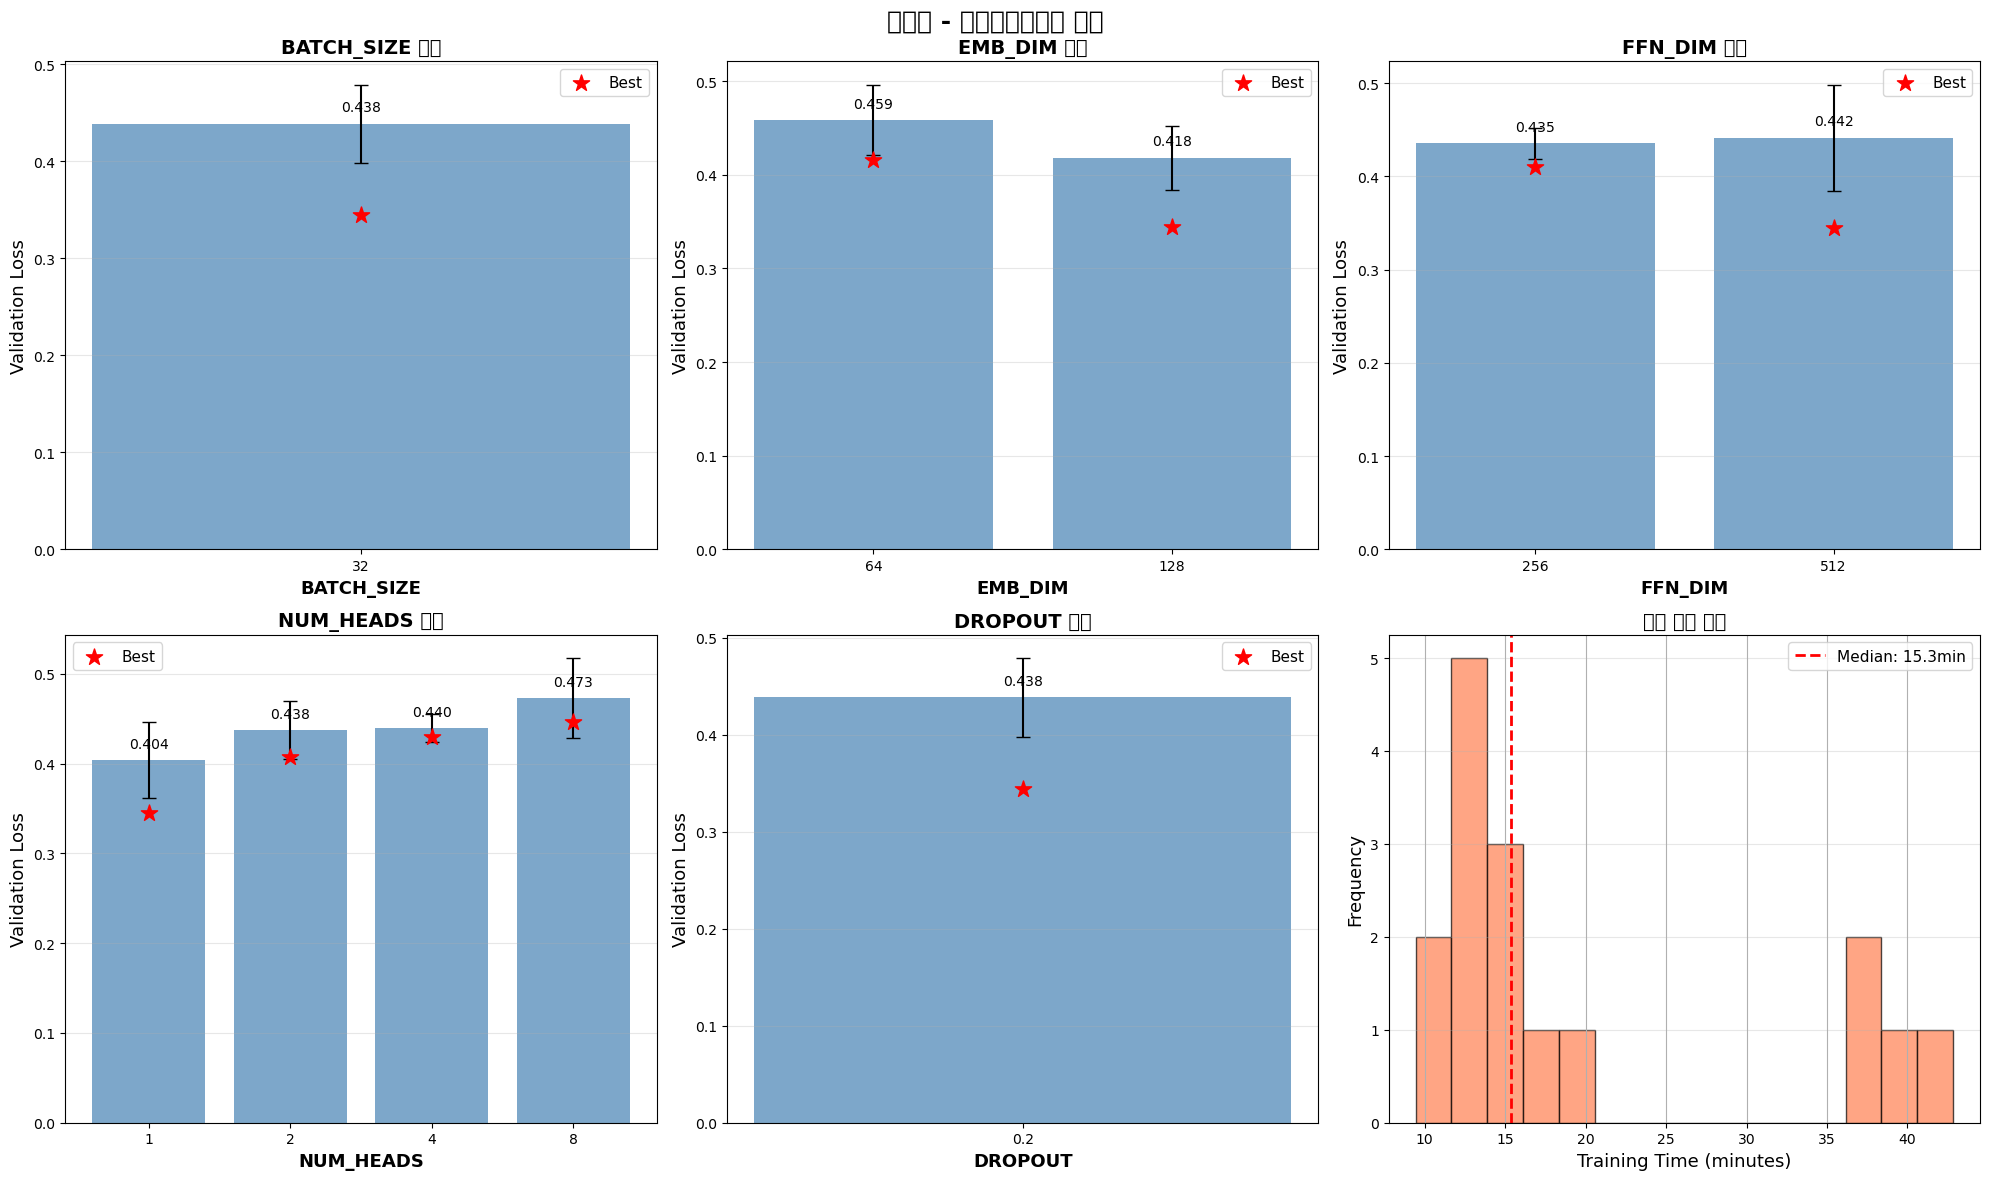


통계 요약
       best_val_loss  best_val_acc  val_f1_macro  val_f1_weighted  \
count      16.000000     16.000000     16.000000        16.000000   
mean        0.438495     85.969130      0.859058         0.859650   
std         0.040628      1.183172      0.011814         0.011760   
min         0.344626     82.793522      0.828408         0.828274   
25%         0.416782     85.399798      0.852777         0.853924   
50%         0.440210     86.133603      0.861627         0.861124   
75%         0.451454     86.437247      0.864781         0.864236   
max         0.539497     88.360324      0.880315         0.883579   

       training_time_min  epochs_trained  
count          16.000000       16.000000  
mean           20.360839       29.687500  
std            11.456984        5.108408  
min             9.438075       19.000000  
25%            13.272438       26.500000  
50%            15.338603       30.000000  
75%            24.353230       32.250000  
max            42.839496   

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results():
    df = tracker.results
    if len(df) == 0:
        print("분석할 결과가 없습니다.")
        return
    
    print("\n" + "="*80)
    print("하이퍼파라미터 효과 분석")
    print("="*80)
    
    params_to_analyze = ['BATCH_SIZE', 'EMB_DIM', 'FFN_DIM', 'NUM_HEADS', 'DROPOUT']
    print("\n각 파라미터별 평균 Validation Loss:")
    print("-"*80)
    for param in params_to_analyze:
        print(f"\n{param}:")
        grouped = df.groupby(param)['best_val_loss'].agg(['mean', 'std', 'min', 'count'])
        print(grouped)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('김완수 - 하이퍼파라미터 분석', fontsize=18, fontweight='bold')
    
    for idx, param in enumerate(params_to_analyze):
        ax = axes[idx // 3, idx % 3]
        grouped = df.groupby(param)['best_val_loss'].agg(['mean', 'std', 'min'])
        x = grouped.index.astype(str)
        y = grouped['mean']
        yerr = grouped['std']
        bars = ax.bar(x, y, yerr=yerr, capsize=5, alpha=0.7, color='steelblue')
        ax.scatter(x, grouped['min'], color='red', s=150, zorder=5, label='Best', marker='*')
        for i, (bar, val) in enumerate(zip(bars, y)):
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
        ax.set_xlabel(param, fontsize=13, fontweight='bold')
        ax.set_ylabel('Validation Loss', fontsize=13)
        ax.set_title(f'{param} 효과', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(axis='y', alpha=0.3)
    
    ax = axes[1, 2]
    df['training_time_min'].hist(bins=15, ax=ax, color='coral', edgecolor='black', alpha=0.7)
    median_time = df['training_time_min'].median()
    ax.axvline(median_time, color='red', linestyle='--', linewidth=2, label=f'Median: {median_time:.1f}min')
    ax.set_xlabel('Training Time (minutes)', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.set_title('학습 시간 분포', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    analysis_path = f'{RESULTS_DIR}/analysis_김완수.png'
    plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ 분석 그래프 저장: {analysis_path}")
    plt.show()
    
    print("\n" + "="*80)
    print("통계 요약")
    print("="*80)
    stats_cols = ['best_val_loss', 'best_val_acc', 'val_f1_macro', 'val_f1_weighted', 'training_time_min', 'epochs_trained']
    print(df[stats_cols].describe())
    
    print("\n" + "="*80)
    print("상관관계 (Validation Loss)")
    print("="*80)
    numeric_cols = ['BATCH_SIZE', 'EMB_DIM', 'FFN_DIM', 'NUM_HEADS', 'DROPOUT']
    correlations = df[numeric_cols + ['best_val_loss']].corr()['best_val_loss'].drop('best_val_loss')
    print(correlations.sort_values())

analyze_results()

In [ ]:
print("\n" + "="*80)
print("📁 생성된 모든 Submission 파일")
print("="*80)

df = tracker.results.sort_values('best_val_loss')

print(f"\n총 {len(df)}개 실험의 submission 파일:")
print("-"*80)

for rank, (idx, row) in enumerate(df.iterrows(), 1):
    print(f"\n{rank}. 실험 {int(row['exp_id'])} (Val Loss: {row['best_val_loss']:.4f})")
    print(f"   📁 {row['submission_file']}")
    if rank == 1:
        print(f"   ⭐ 최고 성능! (이 파일이 submission.csv로 복사됨)")

print("\n" + "="*80)
print("✅ 모든 작업 완료!")
print("="*80)
print(f"\n최종 제출 파일: {SUBMIT_PATH}")
print(f"실험 결과 CSV: {tracker.csv_path}")
print(f"분석 그래프: {RESULTS_DIR}/analysis_김완수.png")
print("\n" + "="*80)


📁 생성된 모든 Submission 파일

총 16개 실험의 submission 파일:
--------------------------------------------------------------------------------

1. 실험 13 (Val Loss: 0.3446)
   📁 ./hyperparameter_results/submission_exp_13.csv
   ⭐ 최고 성능! (이 파일이 submission.csv로 복사됨)

2. 실험 14 (Val Loss: 0.4075)
   📁 ./hyperparameter_results/submission_exp_14.csv

3. 실험 9 (Val Loss: 0.4099)
   📁 ./hyperparameter_results/submission_exp_9.csv

4. 실험 5 (Val Loss: 0.4163)
   📁 ./hyperparameter_results/submission_exp_5.csv

5. 실험 10 (Val Loss: 0.4169)
   📁 ./hyperparameter_results/submission_exp_10.csv

6. 실험 11 (Val Loss: 0.4291)
   📁 ./hyperparameter_results/submission_exp_11.csv

7. 실험 3 (Val Loss: 0.4310)
   📁 ./hyperparameter_results/submission_exp_3.csv

8. 실험 15 (Val Loss: 0.4360)
   📁 ./hyperparameter_results/submission_exp_15.csv

9. 실험 1 (Val Loss: 0.4444)
   📁 ./hyperparameter_results/submission_exp_1.csv

10. 실험 16 (Val Loss: 0.4461)
   📁 ./hyperparameter_results/submission_exp_16.csv

11. 실험 2 (Val Loss: 0.446

---

# 단일 실행 코드 (참고용 - 주석 처리됨)

**아래 섹션은 단일 모델 실행용 코드입**

**하이퍼파라미터 �닝을 실행하려면 위의 하이퍼파라미터 서치 섹션을 사용**



# 5. 데이터 로더 생성

In [ ]:
# # 데이터로더 생성 (기존 함수 사용)
# train_loader, val_loader, test_loader, vocab = create_dataloaders(
#     TRAIN_PATH,  # aug_hub_agg_cleaned.csv 직접 사용
#     TEST_PATH, 
#     vocab_size=VOCAB_SIZE,
#     max_length=MAX_LENGTH,
#     batch_size=BATCH_SIZE,
# )

# print(f"\n✓ DataLoaders created successfully!")
# print(f"  Vocabulary size: {len(vocab)}")
# print(f"  Max sequence length: {MAX_LENGTH}")
# print(f"  Batch size: {BATCH_SIZE}")
# print(f"  Train batches: {len(train_loader)}")
# print(f"  Test batches: {len(test_loader)}")


# 6. 모델 선언

In [ ]:
# # 모델 설정
# config = easydict.EasyDict({
#     "vocab_size": len(vocab),
#     "pad_idx": vocab.PAD_ID,
#     "eos_idx": vocab.EOS_ID,
#     "cls_idx": vocab.CLS_ID,
#     "emb_dim": EMBEDDING_DIM,
#     "ffn_dim": FFN_DIM,
#     "num_heads": NUM_HEADS,
#     "num_layers": NUM_LAYERS,
#     "max_seq_len": MAX_LENGTH,
#     "num_classes": NUM_CLASSES,
#     "dropout": DROPOUT,
# })

# # ⚡ CHANGE: Use GPT1Classifier (no LM head)
# model = GPT1Classifier(config).to(device)

# # 파라미터 수 계산
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"\n{'='*60}")
# print(f"Model Configuration (CLASSIFICATION ONLY)")
# print(f"{'='*60}")
# for key, value in config.items():
#     print(f"  {key:20s}: {value}")
# print(f"\n  {'Total Parameters':20s}: {total_params:,}")
# print(f"{'='*60}\n")

# print("⚡ Changes from original:")
# print("  - Removed Language Modeling Head")
# print("  - Classification-only model")
# print("  - Expect faster convergence & better accuracy!")

# 7. loss function, optimizer 정의

In [ ]:
# # ⚡ CHANGE: Simple Classification Loss (NO Multi-task)
# criterion = nn.CrossEntropyLoss()

# # Optimizer with weight decay
# optimizer = optim.Adam()
# # optimizer = optim.AdamW(
# #     model.parameters(),
# #     lr=LEARNING_RATE,  # Slightly higher LR since no LM task
# #     betas=(0.9, 0.98),
# #     eps=1e-9,
# #     weight_decay=0.05  # L2 regularization
# # )

# # Learning Rate Scheduler
# def get_lr_scheduler(optimizer, warmup_steps, total_steps):
#     def lr_lambda(current_step):
#         if current_step < warmup_steps:
#             return float(current_step) / float(max(1, warmup_steps))
#         progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
#         return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
#     return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# warmup_steps = 500
# total_steps = len(train_loader) * 30
# scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

# print(f"✓ Training setup complete! (CLASSIFICATION ONLY)")
# print(f"  Loss: CrossEntropyLoss (no multi-task)")
# print(f"  Initial LR: {optimizer.param_groups[0]['lr']}")
# print(f"  Warmup steps: {warmup_steps}, Total steps: {total_steps}")

# 8. 단일 모델 훈련 (선택사항)

**이 섹션은 단일 모델 테스트용입니다.**

**21개 조합 하이퍼파라미터 튜닝을 원하면:**
→ 이 섹션을 건너뛰고 **맨 아래 "🔬 하이퍼파라미터 튜닝" 섹션**으로 가세요!

In [ ]:
# best_val_loss = float('inf')
# patience_counter = 0

# # Training history
# history = {
#     'train_loss': [],
#     'val_loss': [],
#     'train_acc': [],
#     'val_acc': []
# }

# print("\n" + "="*60)
# print("Start Training (CLASSIFICATION ONLY - NO LM)")
# print("="*60 + "\n")

# for epoch in range(1, NUM_EPOCHS + 1):
#     # Train
#     train_loss, train_acc = train_epoch(
#         model, train_loader, optimizer, criterion, scheduler, device, epoch
#     )
    
#     # Validate
#     val_loss, val_acc = validate_epoch(
#         model, val_loader, criterion, device, epoch
#     )
    
#     # Save history
#     history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss)
#     history['train_acc'].append(train_acc)
#     history['val_acc'].append(val_acc)
    
#     # Print epoch summary
#     print(f"\nEpoch {epoch}/{NUM_EPOCHS}:")
#     print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
#     print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
#     # ⚡ Check overfitting gap
#     gap = train_acc - val_acc
#     if gap > 15:
#         print(f"  ⚠️  WARNING: Overfitting gap = {gap:.2f}%")
    
#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': val_loss,
#             'val_acc': val_acc,
#         }, BEST_MODEL_PATH)
#         print(f"  ✓ Model saved! (Val Loss: {val_loss:.4f})")
#     else:
#         patience_counter += 1
#         print(f"  No improvement ({patience_counter}/{PATIENCE})")
        
#         if patience_counter >= PATIENCE:
#             print(f"\n⚠️  Early stopping triggered at epoch {epoch}")
#             break
    
#     print("-" * 60)

# print("\n" + "="*60)
# print("Training Complete!")
# print("="*60)
# print(f"Best Validation Loss: {best_val_loss:.4f}")
# print(f"Best Validation Acc: {max(history['val_acc']):.2f}%")

# 9. 훈련 결과 시각화

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Loss plot
# axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
# axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].set_title('Training vs Validation Loss')
# axes[0].legend()
# axes[0].grid(True)

# # Accuracy plot
# axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
# axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Accuracy (%)')
# axes[1].set_title('Training vs Validation Accuracy')
# axes[1].legend()
# axes[1].grid(True)

# plt.tight_layout()
# plt.savefig('./Images/training_history_classification_only.png', dpi=300)
# plt.show()

# print("✓ Training history saved to 'training_history_classification_only.png'")

# 10. 개선된 Test Prediction & Submission


In [ ]:
# # 클래스 매핑
# CLASS_NAMES = {
#     0: '협박 대화',
#     1: '갈취 대화',
#     2: '기타 괴롭힘 대화',
#     3: '직장 내 괴롭힘 대화',
#     4: '일반 대화'
# }

# # ===========================================================================
# # Step 1: Test Prediction
# # ===========================================================================
# print("="*70)
# print("Test Prediction & Submission Generation")
# print("="*70)

# # Load best model
# checkpoint = torch.load(BEST_MODEL_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])

# print(f"\n✓ Loaded best model from epoch {checkpoint['epoch']}")
# print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
# print(f"  Val Acc: {checkpoint['val_acc']:.2f}%")

# # Test prediction
# model.eval()
# predictions = []

# with torch.no_grad():
#     for batch in tqdm(test_loader, desc="Predicting"):
#         input_ids = batch['input_ids'].to(device)
#         cls_logits = model(input_ids)
#         _, predicted = torch.max(cls_logits, 1)
#         predictions.extend(predicted.cpu().numpy())

# # ===========================================================================
# # Step 2: Create Submission (올바른 형식)
# # ===========================================================================
# print("\n" + "="*70)
# print("Submission File Generation")
# print("="*70)

# submission = pd.DataFrame({
#     'idx': [f't_{i:03d}' for i in range(len(predictions))],
#     'target': predictions
# })

# submission.to_csv(SUBMIT_PATH, index=False)
# print(f"\n✓ Submission saved: submission.csv") 
# print(f"  Format: idx (t_000, t_001, ...), target (0, 1, 2, 3, 4)")
# print(f"  Total predictions: {len(predictions)}")

# # ===========================================================================
# # Step 3: Prediction Distribution
# # ===========================================================================
# print("\n" + "="*70)
# print("Prediction Distribution")
# print("="*70)

# pred_counts = Counter(predictions)

# print("\n예측 결과 분포:")
# print("-" * 70)
# for label in sorted(pred_counts.keys()):
#     class_name = CLASS_NAMES.get(label, f'Unknown({label})')
#     count = pred_counts[label]
#     percentage = count / len(predictions) * 100
#     bar = '█' * int(percentage / 2)
#     print(f"{label} {class_name:20s}: {count:3d} ({percentage:5.1f}%) {bar}")

# print(f"\n총 예측 수: {len(predictions)}")

# # Submission Preview
# print("\n" + "="*70)
# print("Submission Preview (첫 10개)")
# print("="*70)

# preview_df = submission.head(10).copy()
# preview_df['class'] = preview_df['target'].map(CLASS_NAMES)
# print(preview_df.to_string(index=False))

# # ===========================================================================
# # Step 4: F1 Score Calculation
# # ===========================================================================
# print("\n" + "="*70)
# print("F1 Score Calculation (Validation Set)")
# print("="*70)

# # Validation prediction
# val_predictions = []
# val_labels = []

# model.eval()
# with torch.no_grad():
#     for batch in tqdm(val_loader, desc="Validating"):
#         input_ids = batch['input_ids'].to(device)
#         labels = batch['labels'].to(device)
        
#         cls_logits = model(input_ids)
#         _, predicted = torch.max(cls_logits, 1)
        
#         val_predictions.extend(predicted.cpu().numpy())
#         val_labels.extend(labels.cpu().numpy())

# # Calculate F1 scores
# f1_macro = f1_score(val_labels, val_predictions, average='macro')
# f1_weighted = f1_score(val_labels, val_predictions, average='weighted')
# f1_per_class = f1_score(val_labels, val_predictions, average=None, zero_division=0)

# print(f"\nOverall F1 Scores:")
# print(f"  Macro F1:    {f1_macro:.4f}")
# print(f"  Weighted F1: {f1_weighted:.4f}")

# print(f"\nPer-Class F1 Scores:")
# print("-" * 70)
# for i, score in enumerate(f1_per_class):
#     if i < len(CLASS_NAMES):
#         class_name = CLASS_NAMES[i]
#         print(f"  {i} {class_name:20s}: {score:.4f}")

# # ===========================================================================
# # Step 5: Classification Report
# # ===========================================================================
# print("\n" + "="*70)
# print("Classification Report")
# print("="*70)

# unique_labels = sorted(set(val_labels))
# target_names = [CLASS_NAMES.get(i, f'Class {i}') for i in unique_labels]

# print("\n" + classification_report(
#     val_labels, 
#     val_predictions, 
#     labels=unique_labels,
#     target_names=target_names,
#     digits=4,
#     zero_division=0
# ))

# # ===========================================================================
# # Step 6: Confusion Matrix
# # ===========================================================================
# print("="*70)
# print("Confusion Matrix")
# print("="*70)

# cm = confusion_matrix(val_labels, val_predictions)
# print("\n행: 실제 (True), 열: 예측 (Predicted)\n")
# print(" " * 8, end="")

# for i in range(len(cm)):
#     print(f"Pred{i:1d}", end="  ")
# print()

# for i, row in enumerate(cm):
#     class_name = CLASS_NAMES.get(i, f'Class {i}')
#     print(f"True{i} ", end="")
#     for val in row:
#         print(f"{val:5d}", end="  ")
#     print(f" | {class_name}")

# # ===========================================================================
# # Step 7: Summary
# # ===========================================================================
# print("\n" + "="*70)
# print("Summary")
# print("="*70)

# print(f"\nSubmission:")
# print(f"  ✓ File: submission.csv")
# print(f"  ✓ Format: idx (t_XXX), target (0-4)")
# print(f"  ✓ Total: {len(predictions)} predictions")

# print(f"\nTest Predictions:")
# most_predicted = max(pred_counts, key=pred_counts.get)
# print(f"  ✓ Most: {CLASS_NAMES[most_predicted]} ({pred_counts[most_predicted]}회)")

# print(f"\nValidation Performance:")
# print(f"  ✓ Macro F1:    {f1_macro:.4f}")
# print(f"  ✓ Weighted F1: {f1_weighted:.4f}")
# print(f"  ✓ Accuracy:    {checkpoint['val_acc']:.2f}%")

# print(f"\nBest Class: {CLASS_NAMES[np.argmax(f1_per_class)]} (F1: {np.max(f1_per_class):.4f})")
# print(f"Worst Class: {CLASS_NAMES[np.argmin(f1_per_class)]} (F1: {np.min(f1_per_class):.4f})")

# print("\n" + "="*70)
# print("All Done!")
# print("="*70)